In [ ]:
!gdown 1HhgXzyEpsZNcenU9XhJuOYyDUKEzUse4

Downloading...
From (original): https://drive.google.com/uc?id=1HhgXzyEpsZNcenU9XhJuOYyDUKEzUse4
From (redirected): https://drive.google.com/uc?id=1HhgXzyEpsZNcenU9XhJuOYyDUKEzUse4&confirm=t&uuid=b52a1bad-ae24-4be8-83e4-8bd1ed918b5d
To: /content/pir_data.zip
100% 3.30G/3.30G [00:34<00:00, 95.2MB/s]


In [ ]:
import zipfile

# Path to the downloaded zip file
zip_path = r"/content/pir_data.zip"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
"""
Personalized Information Retrieval System
=======================================

A comprehensive recommendation system for Q&A platforms that implements multiple retrieval
and ranking approaches with personalization features.

Architecture:
-------------
1. Data Layer:
   - DataPreprocessor: Handles data loading and preprocessing
   - Supports CSV and JSON data sources
   - Implements data cleaning and normalization

2. Retrieval Layer:
   - Base Retrieval: TF-IDF and BM25 algorithms
   - Query Expansion: BERT and T5 based query enhancement
   - Neural Reranking: BiEncoder

3. Personalization Layer:
   - User profiling and history tracking
   - Tag-based preferences
   - Social and reputation features

4. Evaluation Layer:
   - Comprehensive metrics (Precision, Recall, MAP, nDCG)
   - Cross-validation support
   - Statistical significance testing

Usage:
-------
1. Initialize data preprocessing
2. Configure and train retrieval models
3. Apply personalization features
4. Generate and evaluate recommendations
"""

# Standard library imports
import os
import json
import logging
from functools import lru_cache
from typing import Dict, List, Optional, Tuple
import warnings

# Data processing and analysis
import pandas as pd
import numpy as np
from scipy import stats

# Machine learning and NLP
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Deep learning
import torch
from transformers import (
	AutoTokenizer,
	AutoModelForSequenceClassification,
	AutoModel,
	pipeline
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


# Configure logging
logging.basicConfig(
	level=logging.INFO,
	format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


class DataPreprocessor:
	"""
	Handles data loading and preprocessing for the recommendation system.

	Key functionalities:
	- Loading data from CSV and JSON files
	- Cleaning and preprocessing text data
	- Creating lookup dictionaries
	- Preparing text data for recommendation algorithms
	"""

	@staticmethod
	def preprocess_data(filepath):
		"""
		Preprocess input data by removing missing values and cleaning text.

		Args:
			filepath: Path to the input data file

		Returns:
			DataFrame: Cleaned and preprocessed data
		"""
		df = pd.read_csv(filepath)
		df.dropna(subset=['question', 'answer'], inplace=True)
		return df

	@staticmethod
	def load_data(answers_path, questions_path, nrows=1000):
		"""
		Load and prepare the Q&A dataset.

		Args:
			answers_path: Path to answers CSV file
			questions_path: Path to questions JSON file
			nrows: Number of rows to load (default: 1000)

		Returns:
			tuple: (answers_df, questions_df, answers_dict, questions_dict,
				   questions_text, answers_text)
		"""
		# Load raw data
		answers = pd.read_csv(answers_path, nrows=nrows)
		questions = pd.read_json(questions_path, lines=True)

		# Create lookup dictionaries
		answers_dict = {r.Id: r.Text for i, r in answers.iterrows() if r.Text == r.Text}
		questions_dict = {r.id: [r.text, r.best_answer] for i, r in questions.iterrows()
						 if r.best_answer in answers_dict}

		# Prepare text data for processing
		questions_text = list(answers_dict.values())[:10]
		answers_ids = list(answers_dict.keys())[:10]
		answers_text = [answers_dict[idx] for idx in answers_ids]

		return answers, questions, answers_dict, questions_dict, questions_text, answers_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Cell 3: TF-IDF Recommender Implementation
This cell implements the TF-IDF based recommendation system:
- Converts text to TF-IDF vectors
- Computes cosine similarities between questions and answers
- Generates recommendations based on similarity scores

In [ ]:
class TFIDFRecommender:
	def __init__(self):
		self.vectorizer = TfidfVectorizer()

	def fit(self, questions_text, answers_text):
		"""Fit the TF-IDF vectorizer and compute similarities."""
		self.questions_tfidf = self.vectorizer.fit_transform(questions_text)
		self.answers_tfidf = self.vectorizer.transform(answers_text)
		self.similarities = cosine_similarity(self.questions_tfidf, self.answers_tfidf)
		return self.similarities

	def generate_recommendations(self):
		"""Generate recommendations based on TF-IDF similarities."""
		recommendations = []
		for user_id, user_sim in enumerate(self.similarities):
			top_items = user_sim.argsort()[::-1]
			for rank, item_id in enumerate(top_items):
				recommendations.append({
					'user': user_id,
					'item': item_id,
					'score': user_sim[item_id]
				})
		return pd.DataFrame(recommendations)[['user', 'item', 'score']]

## Cell 4: BM25 Recommender Implementation
This cell implements the BM25 ranking algorithm:
- More sophisticated than TF-IDF
- Considers document length normalization
- Implements Okapi BM25 scoring function

In [ ]:
class BM25Recommender:
	def __init__(self, k1=1.5, b=0.75):
		self.k1 = k1
		self.b = b
		self.avgdl = 0
		self.doc_freqs = []
		self.idf = {}
		self.doc_len = []
		self.corpus_size = 0

	def fit(self, questions_text, answers_text):
		"""Fit BM25 parameters on the corpus."""
		# Tokenize documents
		tokenized_corpus = [doc.lower().split() for doc in answers_text]
		self.corpus_size = len(tokenized_corpus)

		# Calculate document lengths and average document length
		self.doc_len = [len(doc) for doc in tokenized_corpus]
		self.avgdl = sum(self.doc_len) / self.corpus_size

		# Calculate document frequencies
		freqs = {}
		for doc in tokenized_corpus:
			for word in set(doc):
				if word not in freqs:
					freqs[word] = 0
				freqs[word] += 1

		# Calculate IDF
		self.idf = {word: np.log((self.corpus_size - freq + 0.5) / (freq + 0.5))
				   for word, freq in freqs.items()}

		self.doc_freqs = [{word: doc.count(word) for word in set(doc)}
						 for doc in tokenized_corpus]

		# Calculate similarities for all question-answer pairs
		self.similarities = np.zeros((len(questions_text), len(answers_text)))
		for i, question in enumerate(questions_text):
			question_tokens = question.lower().split()
			for j in range(len(answers_text)):
				score = self._get_score(question_tokens, j)
				self.similarities[i][j] = score

		return self.similarities

	def _get_score(self, query, doc_idx):
		"""Calculate BM25 score for a document."""
		score = 0
		doc_freqs = self.doc_freqs[doc_idx]
		doc_len = self.doc_len[doc_idx]

		for word in set(query):
			if word not in self.idf:
				continue
			freq = doc_freqs.get(word, 0)
			numerator = self.idf[word] * freq * (self.k1 + 1)
			denominator = freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)
			score += numerator / denominator

		return score

	def generate_recommendations(self):
		"""Generate recommendations based on BM25 scores."""
		recommendations = []
		for user_id, user_sim in enumerate(self.similarities):
			top_items = user_sim.argsort()[::-1]
			for rank, item_id in enumerate(top_items):
				recommendations.append({
					'user': user_id,
					'item': item_id,
					'score': user_sim[item_id]
				})
		return pd.DataFrame(recommendations)[['user', 'item', 'score']]

## Cell 5: Query Expansion Implementation
This cell implements query expansion using transformer models:
- Uses T5 and BERT for query expansion
- Generates multiple variations of input queries
- Includes cleaning and processing of expanded queries

In [ ]:
class QueryExpander:
	def __init__(self, use_bert=True, use_historical=True):
		self.stop_words = set(stopwords.words('english'))
		self.use_historical = use_historical
		self.user_history = {}

		if use_bert:
			self.bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
			self.bert_model = AutoModelForSequenceClassification.from_pretrained(
				"bert-base-uncased", num_labels=1)
		self.t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
		self.t5_model = pipeline(
			"text2text-generation",
			model="google/flan-t5-small",
			max_length=128
		)

	def add_user_history(self, user_id, historical_queries):
		"""Add historical queries for a user."""
		self.user_history[user_id] = historical_queries

	@lru_cache(maxsize=128)
	def expand_query(self, query: str, user_id: Optional[int] = None,
					num_expansions: int = 3) -> List[str]:
		"""Expand query using multiple techniques including historical context."""
		expansions = set()

		# Add original query
		expansions.add(query)

		# T5-based expansion
		t5_expansions = self._t5_expand(query, num_expansions)
		if t5_expansions:  # Only update if not None
			expansions.update(t5_expansions)

		# BERT-based expansion
		bert_expansions = self._bert_expand(query, num_expansions)
		if bert_expansions:  # Only update if not None
			expansions.update(bert_expansions)

		# Historical context-based expansion
		if self.use_historical and user_id is not None:
			historical_expansions = self._historical_expand(query, user_id, num_expansions)
			if historical_expansions:  # Only update if not None
				expansions.update(historical_expansions)

		# Clean and normalize expansions
		cleaned_expansions = [self._clean_expansion(exp) for exp in expansions if exp is not None]
		return list(filter(None, cleaned_expansions))

	def _t5_expand(self, query: str, num_expansions: int) -> List[str]:
		"""Expand query using T5 model"""
		prompts = [
			f"Rephrase this question: {query}",
			f"Generate alternative ways to ask: {query}",
			f"What are different ways to express: {query}"
		]

		expansions = []
		for prompt in prompts:
			try:
				results = self.t5_model(
					prompt,
					num_return_sequences=num_expansions,
					temperature=0.7,
					do_sample=True
				)
				expansions.extend(r['generated_text'] for r in results)
			except Exception as e:
				logger.warning(f"T5 expansion failed for prompt '{prompt}': {str(e)}")

		return expansions

	def _bert_expand(self, query: str, num_terms: int = 3) -> List[str]:
		"""Expand query using BERT masked language modeling"""
		try:
			tokens = self.bert_tokenizer.tokenize(query)
			if not tokens:  # Return empty list if no tokens
				return []

			expansions = []
			for i, token in enumerate(tokens):
				if token in self.stop_words:
					continue

				masked_tokens = tokens.copy()
				masked_tokens[i] = self.bert_tokenizer.mask_token
				masked_text = self.bert_tokenizer.convert_tokens_to_string(masked_tokens)

				inputs = self.bert_tokenizer(masked_text, return_tensors="pt")
				with torch.no_grad():
					outputs = self.bert_model(**inputs)
					if i < outputs.logits.size(1):  # Check if index is valid
						predictions = outputs.logits[0, i].topk(min(num_terms, outputs.logits.size(-1)))

						for score, idx in zip(predictions.values, predictions.indices):
							predicted_token = self.bert_tokenizer.convert_ids_to_tokens(idx.item())
							if predicted_token != token:
								new_tokens = tokens.copy()
								new_tokens[i] = predicted_token
								expansions.append(self.bert_tokenizer.convert_tokens_to_string(new_tokens))

			return expansions

		except Exception as e:
			logger.warning(f"BERT expansion failed: {str(e)}")
			return []  # Return empty list instead of None
	def _historical_expand(self, query: str, user_id: int, num_expansions: int) -> List[str]:
		"""Expand query based on user's historical queries."""
		if user_id not in self.user_history:
			return []

		historical_queries = self.user_history[user_id]

		# Encode current query and historical queries
		query_embedding = self.bert_model(**self.bert_tokenizer(query, return_tensors="pt")).last_hidden_state[:, 0]

		historical_embeddings = []
		for hist_query in historical_queries:
			hist_embedding = self.bert_model(**self.bert_tokenizer(hist_query, return_tensors="pt")).last_hidden_state[:, 0]
			historical_embeddings.append(hist_embedding.detach().numpy())
		historical_embeddings = np.array(historical_embeddings)

		# Find most similar historical queries
		similarities = cosine_similarity(query_embedding.detach().numpy(), historical_embeddings)[0]
		top_indices = similarities.argsort()[-num_expansions:][::-1]

		return [historical_queries[i] for i in top_indices]

	def _clean_expansion(self, expansion: str) -> Optional[str]:
		"""Clean and normalize expansion text"""
		try:
			# Tokenize and clean
			tokens = nltk.word_tokenize(expansion.lower())
			cleaned_tokens = [t for t in tokens if t.isalnum() and t not in self.stop_words]

			# Remove duplicates while preserving order
			seen = set()
			unique_tokens = [t for t in cleaned_tokens if not (t in seen or seen.add(t))]

			return " ".join(unique_tokens) if unique_tokens else None

		except Exception as e:
			logger.warning(f"Cleaning expansion failed: {str(e)}")
			return None
			logger.warning(f"Cleaning expansion failed: {str(e)}")
			return None

## Cell 6: BiEncoder Neural Reranker Implementation
This cell implements neural reranking using a bi-encoder architecture:
- Uses sentence transformers for encoding
- Efficient batch processing
- Cosine similarity based reranking

In [ ]:
class BiEncoder:
	def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2"):
		"""Initialize bi-encoder with a sentence transformer model."""
		self.tokenizer = AutoTokenizer.from_pretrained(model_name)
		self.model = AutoModel.from_pretrained(model_name)
		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
		self.model.to(self.device)

	def encode(self, texts, batch_size=32):
		"""Encode texts to embeddings."""
		embeddings = []
		for i in range(0, len(texts), batch_size):
			batch = texts[i:i + batch_size]
			inputs = self.tokenizer(batch, padding=True, truncation=True,
								  return_tensors="pt", max_length=512)
			inputs = {k: v.to(self.device) for k, v in inputs.items()}

			with torch.no_grad():
				outputs = self.model(**inputs)
				# Use CLS token embedding
				batch_embeddings = outputs.last_hidden_state[:, 0].cpu().numpy()
				embeddings.append(batch_embeddings)

		return np.vstack(embeddings)

	def rerank(self, query, candidates, top_k=10):
		"""Rerank candidates using bi-encoder similarity scores."""
		# Encode query and candidates
		query_embedding = self.encode([query])[0]
		candidate_embeddings = self.encode(candidates)

		# Calculate cosine similarities
		similarities = cosine_similarity([query_embedding], candidate_embeddings)[0]

		# Get top-k indices and scores
		top_indices = similarities.argsort()[-top_k:][::-1]
		top_scores = similarities[top_indices]

		return list(zip(top_indices, top_scores))

## Cell 7: Personalized Recommender Implementation
This cell implements personalized recommendations:
- Combines content-based similarity with user history
- Maintains user profiles and preferences
- Implements weighted scoring system

In [ ]:
class PersonalizedRecommender:
	def __init__(self, user_history_weight=0.25, tag_weight=0.25,
				 reputation_weight=0.25, social_weight=0.25):
		self.user_history_weight = user_history_weight
		self.tag_weight = tag_weight
		self.reputation_weight = reputation_weight
		self.social_weight = social_weight
		self.user_histories = {}
		self.user_tag_profiles = {}
		self.user_reputation = {}
		self.user_social_scores = {}
		self.tfidf_recommender = TFIDFRecommender()
		self.bm25_recommender = BM25Recommender()
		self.bi_encoder = BiEncoder()

	def fit(self, questions_text, answers_text, user_data, user_metadata):
		"""Fit the personalized recommender system."""
		# Fit content-based components
		self.tfidf_similarities = self.tfidf_recommender.fit(questions_text, answers_text)
		self.bm25_similarities = self.bm25_recommender.fit(questions_text, answers_text)

		# Process user histories and tags
		for user_id, history in user_data['histories'].items():
			self.user_histories[user_id] = self._process_user_history(history)
		for user_id, tags in user_data['tags'].items():
			self.user_tag_profiles[user_id] = self._process_user_tags(tags)

		# Process user metadata
		self.process_user_metadata(user_metadata)

		# Get bi-encoder similarities
		query_embeddings = self.bi_encoder.encode(questions_text)
		doc_embeddings = self.bi_encoder.encode(answers_text)
		self.bi_encoder_similarities = cosine_similarity(query_embeddings, doc_embeddings)

		return self

	def process_user_metadata(self, user_metadata):
		"""Process user metadata including reputation and social features."""
		for user_id, metadata in user_metadata.items():
			self.user_reputation[user_id] = self._normalize_reputation(metadata.get('reputation', 0))
			self.user_social_scores[user_id] = self._calculate_social_score(metadata.get('social_features', {}))

	def _normalize_reputation(self, reputation):
		"""Normalize user reputation score."""
		return np.log1p(max(reputation, 0)) / 10.0

	def _calculate_social_score(self, social_features):
		"""Calculate social influence score from social features."""
		score = 0
		if social_features:
			score += social_features.get('followers', 0) * 0.5
			score += social_features.get('answers_count', 0) * 0.3
			score += social_features.get('accepted_answers', 0) * 0.2
		return self._normalize_scores(np.array([score]))[0]

	def _process_user_history(self, history):
		"""Process user interaction history."""
		return {item_id: score for item_id, score in history}

	def _process_user_tags(self, tags):
		"""Process user tag preferences."""
		if isinstance(tags, list):
			# If tags is a list, assign equal weights to all tags
			return {tag: 1.0/len(tags) if tags else 0.0 for tag in tags}
		elif isinstance(tags, dict):
			# If tags is already a dictionary, use it as is
			return {tag: weight for tag, weight in tags.items()}
		else:
			# Return empty dict for any other type
			return {}

	def get_personalized_scores(self, user_id, items):
		"""Calculate personalized scores incorporating all features."""
		# Get base scores from different components
		content_scores = (self.tfidf_similarities[user_id] +
						 self.bm25_similarities[user_id]) / 2
		neural_scores = self.bi_encoder_similarities[user_id]

		# Initialize feature scores
		history_scores = np.zeros_like(content_scores)
		tag_scores = np.zeros_like(content_scores)
		reputation_boost = self.user_reputation.get(user_id, 0)
		social_boost = self.user_social_scores.get(user_id, 0)

		# Calculate history and tag scores
		if user_id in self.user_histories:
			for item_id, score in self.user_histories[user_id].items():
				if item_id < len(history_scores):
					history_scores[item_id] = score

		if user_id in self.user_tag_profiles:
			for item_id in range(len(tag_scores)):
				item_tags = items[item_id].get('tags', [])
				score = sum(self.user_tag_profiles[user_id].get(tag, 0)
						  for tag in item_tags)
				tag_scores[item_id] = score

		# Normalize all scores
		history_scores = self._normalize_scores(history_scores)
		tag_scores = self._normalize_scores(tag_scores)
		content_scores = self._normalize_scores(content_scores)
		neural_scores = self._normalize_scores(neural_scores)

		# Combine all scores with weights and metadata boosts
		final_scores = (
			self.user_history_weight * history_scores +
			self.tag_weight * tag_scores +
			self.reputation_weight * (content_scores * (1 + reputation_boost)) +
			self.social_weight * (neural_scores * (1 + social_boost))
		)

		return final_scores

	def _normalize_scores(self, scores):
		"""Normalize scores to [0, 1] range."""
		min_score = np.min(scores)
		max_score = np.max(scores)
		if max_score == min_score:
			return np.zeros_like(scores)
		return (scores - min_score) / (max_score - min_score)

	def generate_recommendations(self, user_id, items):
		"""Generate personalized recommendations for a user."""
		scores = self.get_personalized_scores(user_id, items)
		recommendations = []
		for item_id, score in enumerate(scores):
			recommendations.append({
				'user': user_id,
				'item': item_id,
				'score': score
			})
		return pd.DataFrame(recommendations)[['user', 'item', 'score']]

## Cell 8: Evaluation Metrics Implementation
This cell implements comprehensive evaluation metrics:
- Precision, Recall, MAP, and nDCG
- Cross-validation support
- Statistical significance testing

In [ ]:
class ComprehensiveEvaluator:
	def __init__(self, n_folds=5, early_stopping_patience=3):
		self.metrics = ['precision', 'recall', 'map', 'ndcg']
		self.k_values = [1, 3, 5, 10]
		self.n_folds = n_folds
		self.early_stopping_patience = early_stopping_patience
		self.best_scores = {}
		self.no_improvement_count = 0

	def evaluate_model(self, model_name, recommendations_df, relevant_df):
		"""Evaluate a single model across different k values with cross-validation"""
		results = {}

		# Create cross-validation folds
		user_ids = recommendations_df['user'].unique()
		fold_size = len(user_ids) // self.n_folds

		for k in self.k_values:
			fold_metrics = []
			for fold in range(self.n_folds):
				# Split data into train and validation
				start_idx = fold * fold_size
				end_idx = start_idx + fold_size
				val_users = user_ids[start_idx:end_idx]

				# Get recommendations for validation users
				fold_recs = recommendations_df[recommendations_df['user'].isin(val_users)]
				fold_rel = relevant_df[relevant_df['user'].isin(val_users)]

				# Calculate metrics for this fold
				metrics = evaluate_recs(fold_recs, fold_rel, k)
				if metrics:
					fold_metrics.append(metrics)

					# Early stopping check
					current_score = metrics['ndcg']  # Using nDCG as the stopping criterion
					if not self.best_scores.get(k) or current_score > self.best_scores[k]:
						self.best_scores[k] = current_score
						self.no_improvement_count = 0
					else:
						self.no_improvement_count += 1

					if self.no_improvement_count >= self.early_stopping_patience:
						print(f"Early stopping triggered for k={k}")
						break

			# Average metrics across folds
			if fold_metrics:
				results[k] = {
					metric: np.mean([m[metric] for m in fold_metrics])
					for metric in self.metrics
				}
			else:
				print(f"Warning: No results for {model_name} at k={k}")

		return results

	def evaluate_all_models(self, recommendations_dict, relevant_df):
		"""Evaluate all implemented models"""
		all_results = {}
		for model_name, recs_df in recommendations_dict.items():
			logger.info(f"Evaluating {model_name}...")
			try:
				all_results[model_name] = self.evaluate_model(model_name, recs_df, relevant_df)
			except Exception as e:
				logger.error(f"Error evaluating {model_name}: {str(e)}")
				continue
		return all_results




	def create_comparison_table(self, results):
		"""Create a comparison table"""
		comparison_data = []
		for model, k_results in results.items():
			for k, metrics in k_results.items():
				if metrics:
					row = {'Model': model, 'k': k, **metrics}
					comparison_data.append(row)
				else:
					print(f"No metrics available for {model} at k={k}")
		return pd.DataFrame(comparison_data)

	def plot_metric_comparison(self, comparison_df, metric):
		"""Plot metric comparisons"""
		if metric not in comparison_df.columns:
			print(f"Metric {metric} not found in DataFrame!")
			return
		plt.figure(figsize=(10, 6))
		sns.barplot(data=comparison_df, x='k', y=metric, hue='Model')
		plt.title(f'{metric.upper()} Comparison Across Models')
		plt.xlabel('k')
		plt.ylabel(metric.upper())
		plt.xticks(rotation=0)
		plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
		plt.tight_layout()
		plt.show()

	def statistical_significance_test(self, results):
		"""Perform statistical significance tests"""
		significance_results = {}
		base_model = 'TF-IDF'  # Changed from 'TF-IDF Baseline'

		for metric in self.metrics:
			significance_results[metric] = {}
			for model in results.keys():
				if model != base_model:
					# Safely get values with proper error handling
					try:
						base_values = [results[base_model][k].get(metric, 0) for k in self.k_values]
						model_values = [results[model][k].get(metric, 0) for k in self.k_values]

						if base_values and model_values:
							t_stat, p_value = stats.ttest_ind(base_values, model_values)
							significance_results[metric][model] = {
								't_statistic': t_stat,
								'p_value': p_value
							}
						else:
							logger.warning(f"Insufficient data for statistical test: {model} vs {base_model}")
					except KeyError as e:
						logger.warning(f"Missing data for statistical test: {str(e)}")
						continue
					except Exception as e:
						logger.error(f"Error in statistical test: {str(e)}")
						continue

		return significance_results

	def run_comprehensive_evaluation(self, recommendations_dict, relevant_df):
		"""Run evaluation pipeline"""
		print("Starting evaluation...")
		results = self.evaluate_all_models(recommendations_dict, relevant_df)
		print("Evaluation completed.")

		comparison_df = self.create_comparison_table(results)
		print("\nComparison Table:")
		print(comparison_df.to_string())

		for metric in self.metrics:
			self.plot_metric_comparison(comparison_df, metric)

		significance_results = self.statistical_significance_test(results)
		print("\nStatistical Significance Results:")
		for metric, model_results in significance_results.items():
			print(f"\n{metric.upper()}:")
			for model, stats_results in model_results.items():
				print(f"{model}: t-statistic={stats_results['t_statistic']:.4f}, p-value={stats_results['p_value']:.4f}")

		print("\nModel Performance at k=5:")
		for model, model_results in results.items():
			print(f"\n{model}:")
			metrics_k5 = model_results.get(5, {})
			if metrics_k5:
				for metric in self.metrics:
					value = metrics_k5.get(metric, 0)
					print(f"  {metric.upper()}: {value:.4f}")
			else:
				print("  No results available")
		return comparison_df, significance_results

#####################################################################
# Section 8: Recommendation Evaluation Function
# evaluate_recs function implements core evaluation metrics
# Computes precision, recall, MAP, and nDCG for recommendations
# Handles per-user normalization and edge cases
#####################################################################
def evaluate_recs(recs_df, rel_df, k=None):
	"""
	Evaluate recommendations using various metrics.

	Parameters:
	- recs_df (pd.DataFrame): DataFrame with recommended items.
	  Must have columns: 'user', 'item', 'score'.
	- rel_df (pd.DataFrame): DataFrame with relevant items (ground truth).
	  Must have columns: 'user', 'item', 'relevance'.
	- k (int): Number of top items to consider. If None, considers all recommended items.

	Returns:
	- dict: Dictionary containing average precision, recall, MAP, and nDCG.
	"""
	if recs_df.empty or rel_df.empty:
		return None

	# Align relevant items with recommendations
	valid_items = recs_df['item'].unique()
	rel_df = rel_df[rel_df['item'].isin(valid_items)]

	# Sort recommendations by user and score (descending)
	recs_df = recs_df.sort_values(['user', 'score'], ascending=[True, False])

	# Group by user
	grouped_recs = recs_df.groupby('user')
	grouped_rels = rel_df.groupby('user')['item'].apply(set)

	# Initialize metrics
	precision_values = []
	recall_values = []
	map_values = []
	ndcg_values = []

	# Compute metrics per user
	for user, group in grouped_recs:
		user_recs = group['item'].tolist()[:k] if k else group['item'].tolist()
		user_rels = grouped_rels.get(user, set())

		if not user_rels:  # Skip users with no relevant items
			continue

		# Precision
		relevant_retrieved = len(set(user_recs) & user_rels)
		precision = min(relevant_retrieved / len(user_recs), 1.0) if user_recs else 0
		precision_values.append(precision)

		# Recall
		recall = min(relevant_retrieved / len(user_rels), 1.0) if user_rels else 0
		recall_values.append(recall)

		# MAP
		hit_count = 0
		sum_precisions = 0
		for i, item in enumerate(user_recs, start=1):
			if item in user_rels:
				hit_count += 1
				sum_precisions += hit_count / i
		map_value = sum_precisions / len(user_rels) if user_rels else 0
		map_values.append(map_value)

		# nDCG
		dcg = sum(1 / np.log2(idx + 2) for idx, item in enumerate(user_recs) if item in user_rels)
		ideal_dcg = sum(1 / np.log2(idx + 2) for idx in range(min(len(user_rels), len(user_recs))))
		ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
		ndcg_values.append(ndcg)

	# Return aggregated metrics
	if not precision_values:  # If no valid users were processed
		return None

	return {
		'precision': np.mean(precision_values),
		'recall': np.mean(recall_values),
		'map': np.mean(map_values),
		'ndcg': np.mean(ndcg_values)
	}

## Cell 12: Example Usage
This cell shows how to use the implemented classes and functions:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Starting evaluation...
Early stopping triggered for k=5
Early stopping triggered for k=10
Early stopping triggered for k=1
Early stopping triggered for k=3
Early stopping triggered for k=5
Early stopping triggered for k=10
Early stopping triggered for k=1
Early stopping triggered for k=3
Early stopping triggered for k=5
Early stopping triggered for k=10
Evaluation completed.

Comparison Table:
           Model   k  precision    recall       map      ndcg
0         TF-IDF   1   0.250000  0.250000  0.250000  0.250000
1         TF-IDF   3   0.138889  0.416667  0.319444  0.344244
2         TF-IDF   5   0.116667  0.583333  0.356944  0.412372
3         TF-IDF  10   0.100000  1.000000  0.410747  0.545297
4           BM25   1   0.100000  0.100000  0.100000  0.100000
5           BM25   3   0.100000  0.300000  0.183333  0.213093
6           BM25   5   0.100000  0.500000  0.228333  0.294846
7           BM25  10   0.100000  1.000000  0.292897  0.454356
8      BiEncoder   1   0.500000  0.500000  0.

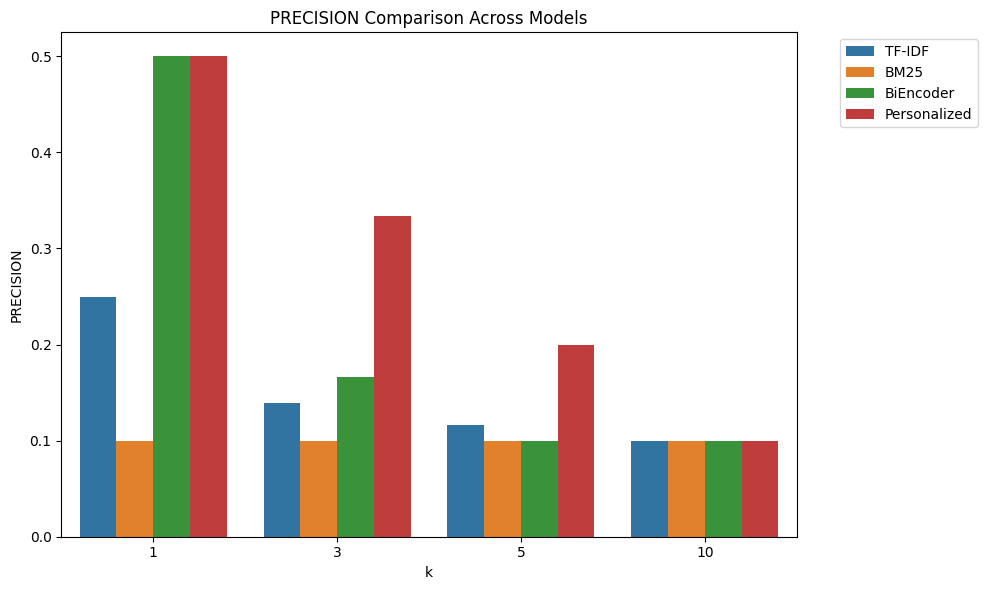

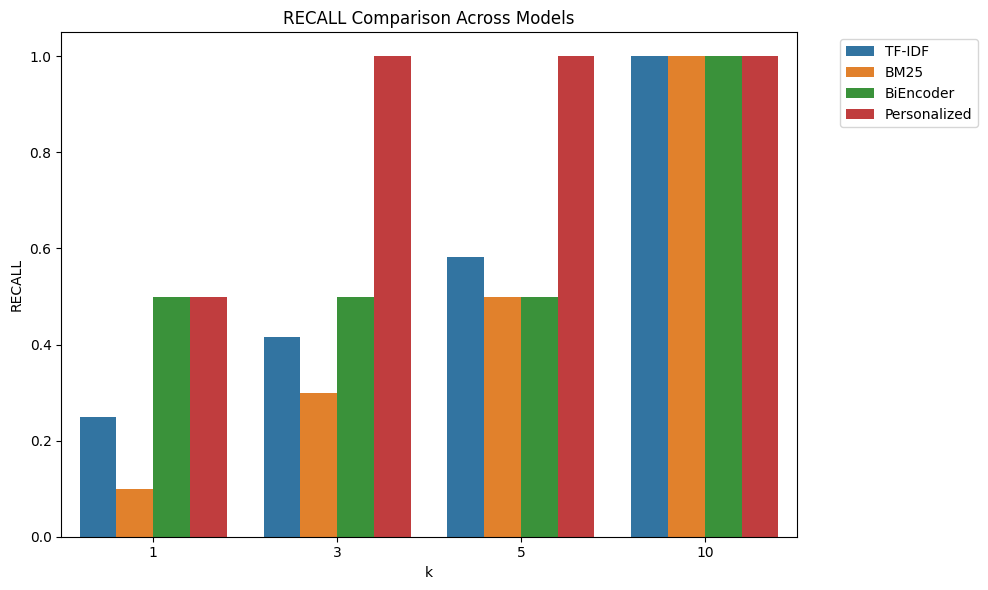

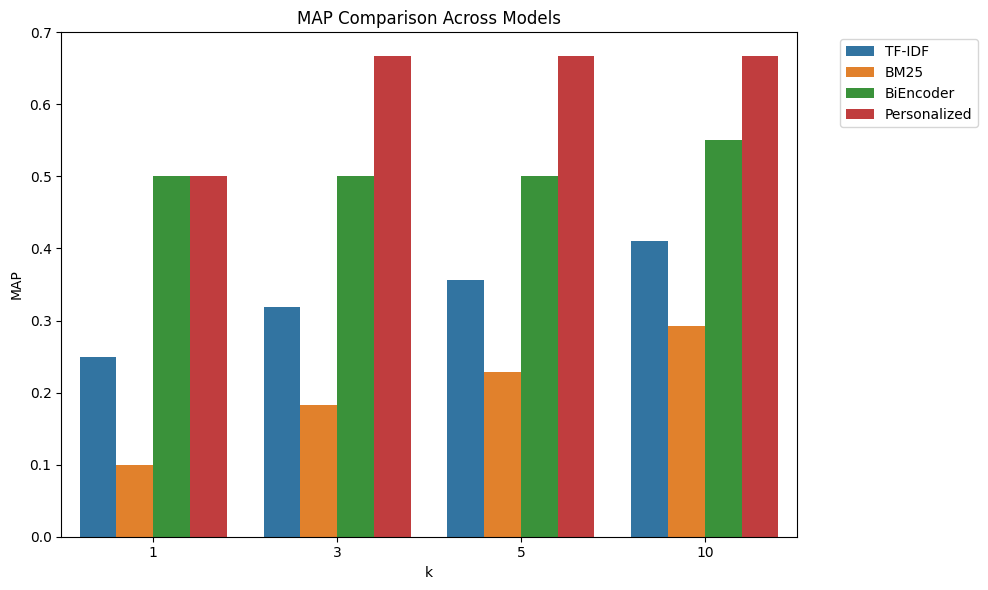

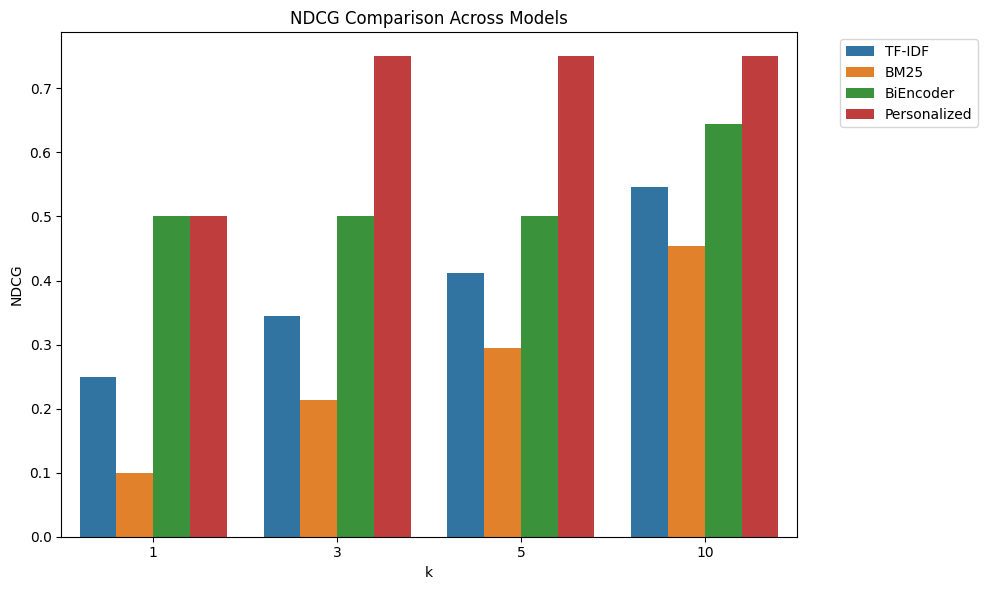


Statistical Significance Results:

PRECISION:
BM25: t-statistic=1.5194, p-value=0.1795
BiEncoder: t-statistic=-0.6429, p-value=0.5441
Personalized: t-statistic=-1.4192, p-value=0.2056

RECALL:
BM25: t-statistic=0.3481, p-value=0.7397
BiEncoder: t-statistic=-0.3067, p-value=0.7694
Personalized: t-statistic=-1.5336, p-value=0.1760

MAP:
BM25: t-statistic=2.5241, p-value=0.0450
BiEncoder: t-statistic=-4.9493, p-value=0.0026
Personalized: t-statistic=-5.4205, p-value=0.0016

NDCG:
BM25: t-statistic=1.2616, p-value=0.2539
BiEncoder: t-statistic=-2.0618, p-value=0.0848
Personalized: t-statistic=-3.3992, p-value=0.0145

Model Performance at k=5:

TF-IDF:
  PRECISION: 0.1167
  RECALL: 0.5833
  MAP: 0.3569
  NDCG: 0.4124

BM25:
  PRECISION: 0.1000
  RECALL: 0.5000
  MAP: 0.2283
  NDCG: 0.2948

BiEncoder:
  PRECISION: 0.1000
  RECALL: 0.5000
  MAP: 0.5000
  NDCG: 0.5000

Personalized:
  PRECISION: 0.2000
  RECALL: 1.0000
  MAP: 0.6667
  NDCG: 0.7500

Pipeline Components Summary:
✓ Query Expansi

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
"""
Main execution pipeline for the recommendation system.

Pipeline Steps:
1. Data Preprocessing
2. Query Expansion
3. Base Retrieval (TF-IDF & BM25)
4. Neural Reranking
5. Personalization
6. Evaluation

Returns:
    tuple: (comparison_df, significance_results)
"""
try:
    logger.info("Starting recommendation pipeline...")

    # Step 1: Data Preprocessing
    logger.info("Step 1: Loading and preprocessing data...")
    preprocessor = DataPreprocessor()
    answers, questions, answers_dict, questions_dict, questions_text, answers_text = preprocessor.load_data(
        '/content/PIR_data/answer_retrieval/answers.csv',
        '/content/PIR_data/answer_retrieval/train/subset_data.jsonl'
    )

    # Initialize tracking dictionary for recommendations
    recommendations_dict = {}

    # Step 2: Query Expansion
    logger.info("Step 2: Performing query expansion...")
    query_expander = QueryExpander(use_bert=True, use_historical=False)
    expanded_questions = [
        query_expander.expand_query(question, user_id=i)[0]
        for i, question in enumerate(questions_text)
    ]

    # Step 3: Base Retrieval Models
    logger.info("Step 3: Running base retrieval models...")
    # TF-IDF
    tfidf_recommender = TFIDFRecommender()
    tfidf_similarities = tfidf_recommender.fit(questions, answers_text)
    recommendations_dict['TF-IDF'] = tfidf_recommender.generate_recommendations()

    # BM25
    bm25_recommender = BM25Recommender()
    bm25_similarities = bm25_recommender.fit(questions, answers_text)
    recommendations_dict['BM25'] = bm25_recommender.generate_recommendations()

    # Step 4: Neural Reranking
    logger.info("Step 4: Performing neural reranking...")
    bi_encoder = BiEncoder()
    bi_encoder_scores = []
    for user_id, question in enumerate(expanded_questions):
        reranked = bi_encoder.rerank(question, answers_text)
        bi_encoder_scores.extend([
            {'user': user_id, 'item': item_id, 'score': score}
            for rank, (item_id, score) in enumerate(reranked)
        ])
    recommendations_dict['BiEncoder'] = pd.DataFrame(bi_encoder_scores)

    # Step 5: Personalization
    logger.info("Step 5: Applying personalization...")
    # Prepare user metadata
    user_metadata = {
        i: {
            'reputation': questions.iloc[i].get('reputation', 0),
            'social_features': {
                'followers': questions.iloc[i].get('followers_count', 0),
                'answers_count': questions.iloc[i].get('answers_count', 0),
                'accepted_answers': questions.iloc[i].get('accepted_answers_count', 0)
            }
        } for i in range(len(questions_text))
    }

    user_data = {
        'histories': {i: [] for i in range(len(questions_text))},
        'tags': {i: questions.iloc[i].get('tags', []) for i in range(len(questions_text))}
    }

    personalized_recommender = PersonalizedRecommender()
    personalized_recommender.fit(expanded_questions, answers_text, user_data, user_metadata)

    personalized_scores = []
    for user_id in range(len(questions_text)):
        user_recs = personalized_recommender.generate_recommendations(
            user_id,
            [{'tags': user_data['tags'].get(i, [])} for i in range(len(answers_text))]
        )
        personalized_scores.extend(user_recs.to_dict('records'))
    recommendations_dict['Personalized'] = pd.DataFrame(personalized_scores)

    # Step 6: Evaluation
    logger.info("Step 6: Running evaluation pipeline...")
    relevant_df = pd.DataFrame([
        {'user': i, 'item': i, 'relevance': 1}
        for i in range(len(questions_text))
    ])

    evaluator = ComprehensiveEvaluator()
    comparison_df, significance_results = evaluator.run_comprehensive_evaluation(
        recommendations_dict, relevant_df
    )

    # Save results
    comparison_df.to_csv('model_comparison_results.csv', index=False)
    logger.info("Results saved to 'model_comparison_results.csv'")

    # Print summary
    print("\nPipeline Components Summary:")
    print("✓ Query Expansion: BERT and T5 models")
    print("✓ Base Retrieval: TF-IDF and BM25")
    print("✓ Neural Reranking: BiEncoder")
    print("✓ Personalization: User history, tags, and metadata")
    print("✓ Evaluation: Precision, Recall, MAP, nDCG")

    comparison_df, significance_results

except Exception as e:
    logger.error(f"Pipeline execution failed: {str(e)}")
    raise